Linear Regression
=====

Linear Regression attempts to predict a continuous outcome feature (**Y**) from one or more explanatory features (**X**).  

$$Y = \beta_0 + \beta_1 X$$

$\beta_0$ is called the intercept term, and represents the expected mean value of Y when all explanatory features equal 0.  
$\beta_1$ is called a beta coefficient, and represents the expected change in the value of Y that results from a one unit change in X.  


Today, we will attempt to construct a linear regression in order to answer a question that loan borrowers may have: 

**What impacts the loan amount requested? **

To ensure that our linear regressor is appropriate and interpretable, we will have to confirm the following assumptions are not violated:

1. Linear relationship between x and y
2. Normality
3. Minimal multicollinearity (if multiple variables)
4. No autocorrelation 
5. Homoscedasticity 
- Additional rule of thumb: at least 20 observations per independent variable in the analysis
  
If these assumptions are violated, then the predictive power of the linear regression is still valid but the information concerning the most important features is not. It is important to keep this in mind!


Here's a look ahead at what we'll be doing in the notebook: 

 Load Data and Build Univariate Linear Regression        
 Check Assumptions  
 Build Multivariate Linear Regression  
 Model Evaluation

1) Import packages
-----

In [97]:
import numpy as np
import pandas as pd

# Packages for checking assumptions
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.set()
sns.set(font_scale=1.5)

# Packages for checking assumptions
from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.formula.api as sm

# Set jupyter notebook preferences
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

2) Load Data
-----

In [98]:
path = 'ML_assignment1/'
filename = 'loans.csv'
df = pd.read_csv(path+filename)

In [99]:
df.head()

,id_number,loan_amount,lender_count,status,funded_date,funded_amount,repayment_term,location_country_code,sector,description,use
0,736066,4825,60,funded,2014-08-03T17:51:50Z,4825,8,BJ,Retail,NaN,NaN
1,743090,975,34,funded,2014-08-18T09:10:54Z,975,12,BJ,Food,NaN,NaN
2,743120,950,25,funded,2014-08-09T17:46:35Z,950,14,BJ,Services,NaN,NaN
3,743121,825,28,funded,2014-08-24T17:00:38Z,825,14,BJ,Retail,NaN,NaN
4,743124,725,21,funded,2014-08-25T03:24:54Z,725,13,BJ,Retail,NaN,NaN


In [100]:
#to count rows 
df.shape[0]

6019

In [101]:
#column count
df.shape[1]

11

In [102]:
df.describe()

,id_number,loan_amount,lender_count,funded_amount,repayment_term
count,6.019000e+03,6019.000000,6019.000000,6019.000000,6019.000000
mean,1.359770e+06,1499.011464,35.661406,1325.070610,11.803290
std,3.719316e+05,2512.517280,73.420256,2444.726815,9.114948
min,1.377200e+04,50.000000,0.000000,0.000000,3.000000
25%,1.425188e+06,300.000000,7.000000,200.000000,8.000000
50%,1.550673e+06,625.000000,16.000000,525.000000,10.000000
75%,1.566204e+06,1825.000000,41.000000,1525.000000,14.000000
max,1.573593e+06,80000.000000,2665.000000,80000.000000,133.000000


Build Univariate Linear Regression
-----

### Train - Test split

Prior to building our model, we first need to split our dataset into a training set and a test set.  We will use our training set to train our regressor, and we will use our test set for model validation.
To achieve this, we will use call sklearn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), and set the input parameter `test_size` to .2 so that 20% of the data will be assigned to the test set and 80% of the data will be assigned to the training set.

**We set the test set aside and only look at this at the end to evaluate the models performance on unseen data.**

We fix the random state so that each time we run the train_test_split code, we get the same distribution of data. This is important as keeping the data split constant allows us to compare results from different sessions. 

In [103]:
#to check column name
df.columns.tolist()

['id_number',
 'loan_amount',
 'lender_count',
 'status',
 'funded_date',
 'funded_amount',
 'repayment_term',
 'location_country_code',
 'sector',
 'description',
 'use']

In [104]:
#convert sector from text to dummy variables data
sector_dummies = pd.get_dummies(df['sector'])

In [105]:
sector_dummies.columns.tolist()

['Agriculture',
 'Arts',
 'Clothing',
 'Construction',
 'Education',
 'Food',
 'Health',
 'Housing',
 'Manufacturing',
 'Personal Use',
 'Retail',
 'Services',
 'Transportation',
 'Wholesale']

In [106]:
#concatenate the newly formed cols with the existing dataset
df_new = pd.concat([df, sector_dummies], axis=1) 

In [107]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'loan_amount'
y = df_new[y_column]
# Define our independent variables
x_columns = ['Agriculture',
 'Arts',
 'Clothing',
 'Construction',
 'Education',
 'Food',
 'Health',
 'Housing',
 'Manufacturing',
 'Personal Use',
 'Retail',
 'Services',
 'Transportation',
 'Wholesale']
X = df_new[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

### Univariate Linear Regression
In order to build our linear regressor, we will use [statsmodels](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) implementation.  The are other implementations out there; however, we will use statmodels because it creates a nice summary table for model evaluation. Let's print out the summary table to demonstrate how easy it is to train the model and see the results.

For an in-depth review on all the statistics and numbers given in the summary below, check out this [awesome page!](http://connor-johnson.com/2014/02/18/linear-regression-with-python/)

In [108]:
model = sm.OLS(endog=y_train, exog=X_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     12.43
Date:                Fri, 08 Feb 2019   Prob (F-statistic):           3.00e-27
Time:                        13:57:39   Log-Likelihood:                -44689.
No. Observations:                4815   AIC:                         8.941e+04
Df Residuals:                    4801   BIC:                         8.950e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Agriculture      -48.8812    114.304     -0.

Model interpretation
-----

This is the typical regression output. It's a lot to digest! 

Remember that our linear regression model can be represented as an equation, like this: 

    loan_amount = intercept + coef*lender_count

What is the intercept value?   

In [109]:
model_fit.params.intercept

1502.4075541440284

What does that intercept value tell us?

<br>
<br>
<br>

What is the coefficent for `lender_count`?

In [110]:
#model_fit.params.lender_count
#model_fit.params.funded_amount
model_fit.params.Retail

31.788118480624

What does that coeffiecent value tell us?

<br>
<br>
<br>
-----

How do we know however, whether this is a significant result?

We have a sufficient amount of confidence in this conclusion because the **p-value** is reported to be 0.000. In technical terms, the p-value is **the probability of getting results as extreme as the ones observed given no correlation. **

In statistics, we want our results to fall within the 95% confidence interval, or the p-value to be <= 0.05. This means, "[i]f repeated samples were taken and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the population mean. A 95% confidence interval has a 0.95 probability of containing the population mean. 95% of the population distribution is contained in the confidence interval." [Read more here.](http://www.investopedia.com/terms/s/standard-error.asp) The p-value is an indicator of where we fall in the confidence interval. In English, small p-value (<= 0.05) indicates strong evidence that the coefficient is different than 0. 

This is a relatively simplified explanation of p-values. Don't worry if it's not immediately intuitive - [not even professional statisticians can easily explain this concept.](http://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) To get a deeper understanding, we recommend grabbing the nearest textbook on statistics to review! 


Let's test our model on our test set.

In [111]:
y_pred_test = model_fit.predict(X_test)

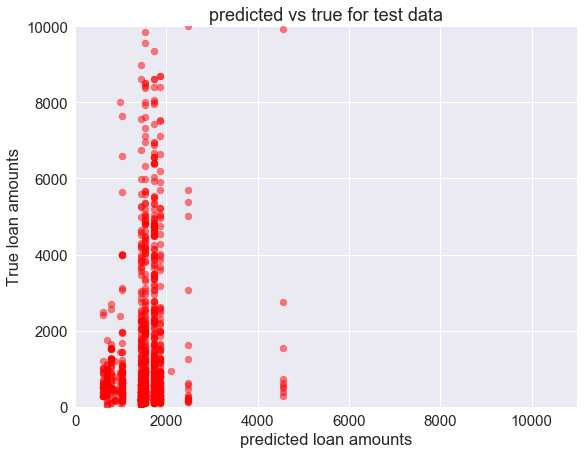

In [112]:
plt.figure(figsize=(9,7))
plt.scatter(y_pred_test, y_test, alpha=0.5, c='r')
plt.title('predicted vs true for test data')
plt.xlabel('predicted loan amounts')
plt.ylabel('True loan amounts')
axes = plt.gca()
axes.set_xlim([0,11000])
axes.set_ylim([0,10000])
plt.show();

<br>
<br> 
<br>

----